# Clasificación de obras
- En este cuaderno vamos a clasificar las obras según su tipo: misa,villancico,etc. y su autor.

In [1]:
%%capture
!sudo apt install tesseract-ocr

In [2]:
%%capture
!sudo apt-get install tesseract-ocr-spa

In [3]:
%%capture
pip install pytesseract

In [4]:
%%capture
pip install tesseract

In [5]:
import cv2
import sys
import pytesseract
from pytesseract import Output
import argparse
import pickle
import re,string
import random
from unicodedata import normalize
import numpy as np
from matplotlib import pyplot as plt
from statistics import mean,stdev
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
with open("Obras.pickle", "rb") as f:
    Obras = pickle.load(f)
with open("ini_Obras.pickle", "rb") as f:
    ini_Obras = pickle.load(f)

In [7]:
%%capture
!unzip /content/drive/MyDrive/Fotos.zip

## Implementando las funciones

In [8]:
def bloques(foto):
  img = foto.copy()
  results = pytesseract.image_to_data(img, output_type=Output.DICT)
  L=[[[],[],[],[]] for i in range (0,len(set(results['block_num'])))]
  for i in range (0, len(results['block_num'])):
    if results['text'][i]!='' and results['text'][i]!=' ':
      j= results['block_num'][i]-1
      L[j][0].append(results['left'][i])
      L[j][1].append(results['top'][i])
      L[j][2].append(results['width'][i])
      L[j][3].append(results['height'][i])
  i=0
  for lista in L:
    if lista!=[[],[],[],[]]:
      x=lista[0][0]-10
      y=lista[1][0]-10
      z1=max(lista[0])
      z=z1+ lista[2][lista[0].index(z1)]+10
      w1=max(lista[1])
      w=w1+ lista[3][lista[1].index(w1)]+3
      cv2.rectangle(img, (x, y), (z,w), (0, 0, 255), 2)
      cv2.putText(img, f'bloque {i}', (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    i=i+1
  return img

- **Detectar los pentagramas**

In [9]:
def pentagramas(foto): 
  foto2 = foto.copy()
  (H,W) = foto.shape[:2]
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  tthreshInv = cv2.resize(threshInv,(int(W*25/100),int(H*25/100)))
  dilate = cv2.dilate(threshInv.copy(),(15,1))
  
  for i in range(0,4):
    dilate = cv2.dilate(dilate,(15,1))

  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 10000):
      #cv2.drawContours(foto2, [c], -1, (119, 90, 17), 2)
      (x, y, w, h) = cv2.boundingRect(c) # Mejor sacar el rectángulo contenido
      cv2.rectangle(foto2, (x, y), (x + w, y + h), (119, 90, 17), 2)
  return foto2

- **Borrar pentagramas**

In [10]:
def pentagramaBlanco(foto):
  (H,W) = foto.shape[:2]
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  tthreshInv = cv2.resize(threshInv,(int(W*25/100),int(H*25/100)))
  dilate = cv2.dilate(threshInv.copy(),(15,1))
  
  for i in range(0,4):
    dilate = cv2.dilate(dilate,(15,1))

  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 10000):
      cv2.drawContours(foto, [c], -1, (255, 255, 255), -1)
      (x, y, w, h) = cv2.boundingRect(c)
      cv2.rectangle(foto, (x, y+40), (x + w, y + h-40), (255, 255, 255), -1)
  return foto

- **Detectar texto**

In [11]:
def espacios(str):
  n = len(str)
  return len([str[i] for i in range(0,n) if str[i]==' ']) == n

def sacarTexto(foto): # Esta función es importante ya que debemos ajustar las cosas bien para poder distinguir cada cosa correctamente.
  
  fotografia = foto.copy()
  foto2 = foto.copy()
  fotografia = pentagramaBlanco(fotografia)
  results = pytesseract.image_to_data(fotografia, lang='spa', output_type=Output.DICT)

  (H,W) = fotografia.shape[:2] # Alto y ancho de la imagen

  for i in range(0, len(results["text"])): # Vamos identificando todas las palabras

    # Sacamos las coordenadas de la palabra
	  x = results["left"][i]
	  y = results["top"][i]
	  w = results["width"][i]
	  h = results["height"][i]
	  # sacamos la palabra 
	  text = results["text"][i]
	  conf = int(results["conf"][i])


	  # Esto es para distinguir texto de otras cosas, si el área que ocupa ese objeto es pequeña entonces es una palabra.
	  if conf > 0.15 and 0 < h < 30 and 8 < w < 350 and not(espacios(text)):

		  text = "".join([c if ord(c) < 300 else "" for c in text]).strip()
		  cv2.rectangle(foto2, (x, y), (x + w, y + h), (0, 255, 0), 2) # Rodeamos la palabra
		  cv2.putText(foto2, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.4, (0, 0, 255), 3) # Ponemos arriba la palabra en formato texto.

  return foto2

- **Guardar el texto**

In [12]:
def remove_punctuation(frase):
  char = re.sub('[%s]' % re.escape(string.punctuation.replace('-','')),'',frase)
  char = char.replace('¿','').replace('?','').replace('`','').replace('´','').replace('#','').lower()
  char = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", char), 0, re.I
    )
  char = normalize( 'NFC', char)
  return char


def guardarTexto(texto,foto,pag): # "texto" es un diccionario, le pasamos una "foto" para que almacene el texto de la página "pag"
  foto = pentagramaBlanco(foto)
  results = pytesseract.image_to_data(foto, lang='spa', output_type=Output.DICT)
  dic = {'text' : [], 'left' : [], 'top' : [], 'width' : [], 'height' : []}
  n = len(results['text'])
  for i in range(0,n):
    x = results['left'][i]
    y = results['top'][i]
    h = results['height'][i]
    w = results['width'][i]
    text = results['text'][i]
    conf = int(results['conf'][i])
    if conf > 0.15 and 0 < h < 30 and 8 < w < 350 and not(espacios(remove_punctuation(text))):
      dic['text'].append(remove_punctuation(text))
      dic['left'].append(x)
      dic['top'].append(y)
      dic['height'].append(h)
      dic['width'].append(w)
  texto[pag] = dic

- **Guardar los pentagramas**

In [13]:
def guardarPentagramas(pentagramas,foto,pag): 
  (H,W) = foto.shape[:2]
  P = []
  gray = cv2.cvtColor(foto,cv2.COLOR_RGB2GRAY)
  (T,threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  tthreshInv = cv2.resize(threshInv,(int(W*25/100),int(H*25/100)))
  dilate = cv2.dilate(threshInv.copy(),(15,1))
  
  for i in range(0,4):
    dilate = cv2.dilate(dilate,(15,1))

  cnts,_ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for c in cnts:
    area = cv2.contourArea(c)
    if(area > 10000):
      P.append(cv2.boundingRect(c))
  pentagramas[pag] = P

In [14]:
def borrarTexto(foto,numPag):
  n = len(texto[numPag]['text'])
  foto2 = foto.copy()
  for i in range(0,n):
    x = texto[numPag]['left'][i]
    y = texto[numPag]['top'][i]
    h = texto[numPag]['height'][i]
    w = texto[numPag]['width'][i]
    cv2.rectangle(foto2, (x-150, y-2), (x + w + 150, y + h+2), (255, 255, 255), -1)
  return foto2

In [15]:
def esNumero(cadena):
  try:
    int(cadena)
    return True
  except:
    return False

In [16]:
def verPagina(num_obra):
  for cla in ini_Obras:
    if num_obra in ini_Obras[cla]: return cla

## Comenzamos con el proceso
- Vamos a tener en cuenta la estructura del libro. Cada Capítulo tiene una estructura diferente.
- Las posibles estructuras para guardar la información pueden ser:
  - $Obra[i] = \{coordenadas : (x,y,w,h), Autor: nombre, Tipo : tipo de obra, pag : página \}$

  - $Autor[nombre] = \{O_1 : \{coordenadas : (x,y,w,h),Tipo : tipo de obra, pag : página\},...,O_n : etc\}$
  
  - $TipoObra[tipo] = \{O_1 : \{coordenadas : (x,y,w,h),Autor : nombre, pag : página\},...,O_n : etc\}$

- En realidad con hacer una de estas tres estructuras es suficiente ya que se puede ir fácilmente de una a otra sin problema.

In [182]:
Obras_final = {}

In [145]:
tipos = ['Misa','Salmo','Villancico','Magnificat','Lamentación','Himno','Rosario','Responsorio','Motete','Otro']

In [148]:
claves = [pag for pag in ini_Obras]
Pagina = {}
for cla in claves:
  foto = cv2.imread('Fotos/pag'+str(cla)+'.jpg')
  foto = cv2.cvtColor(foto,cv2.COLOR_BGR2RGB)
  Pagina[cla] = foto

In [146]:
Capitulo = {1:list(range(1,24)),2:list(range(25,35)),3:list(range(35,56)),4:list(range(57,69)),5:list(range(69,77)),6:list(range(77,103)),7:list(range(103,112)),8:list(range(113,142)),9:list(range(143,153)),10:list(range(153,181)),11:list(range(181,205)),12:list(range(205,222)),13:list(range(223,247)),14:list(range(247,337)),15:list(range(337,346)),16:list(range(347,384))}

- **Borramos los recuadros de las obras**

In [ ]:
for i in range(1,1554):
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    cv2.rectangle(Pagina[pag+j], (x, y), (x+w,y+h), (255, 255, 255), -1)

- **Mostramos una imagen**

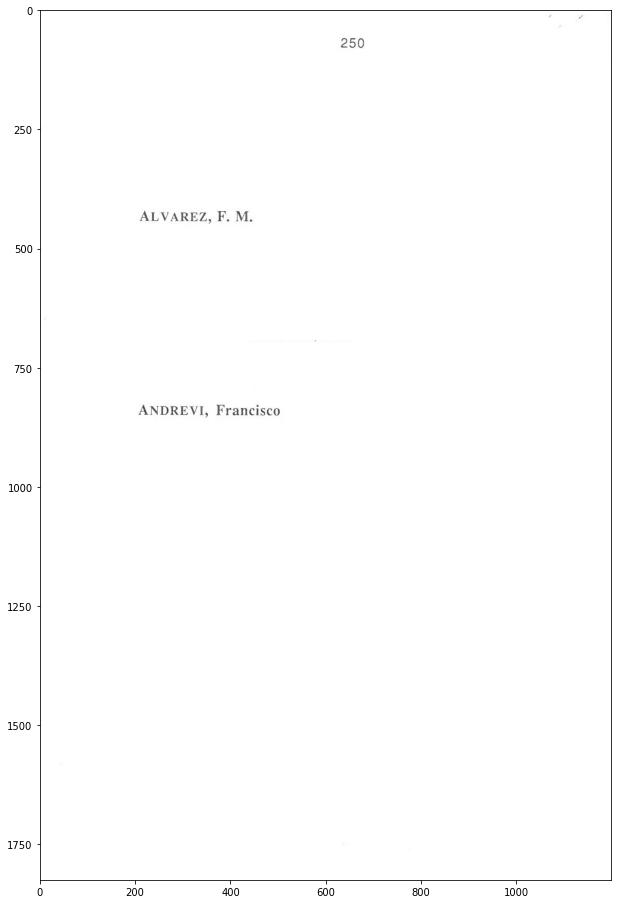

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(16,16))
ax.imshow(Pagina[250])
plt.show()

### Nos ayudamos del índice onomástico del libro para guardar el nombre de todos los autores

In [34]:
Fotos = []
for i in range(384,390):
  if i%2 == 0:
    pag = cv2.imread('pag' + str(i+1) + '.jpg')
    pag = cv2.cvtColor(pag, cv2.COLOR_BGR2RGB)
    pag = pag[:1825,175:1375]
    Fotos.append(pag)
  if i%2 == 1:
    pag = cv2.imread('pag' + str(i+1) + '.jpg')
    pag = cv2.cvtColor(pag, cv2.COLOR_BGR2RGB)
    pag = pag[198:,:1200]
    Fotos.append(pag)

In [49]:
def mostrar_Autores(foto):
  foto1 = foto.copy()
  results = pytesseract.image_to_data(foto1, lang='spa', output_type=Output.DICT)
  x1 = results["left"][0]
  y1 = results["top"][0]
  w1 = results["width"][0]
  h1 = results["height"][0]
  texto = results["text"][0]
  for i in range(1,len(results['text'])):
    x = results["left"][i]
    y = results["top"][i]
    w = results["width"][i]
    h = results["height"][i]
    text = results["text"][i]
    conf = int(results["conf"][i])
    if conf > 0.15 and 0 < h < 30 and 8 < w < 350 and not(espacios(text)) and not(esNumero(text[:1])):
      if abs(y1-y) < 10:
        texto = texto + ' ' + text
        w1 = x-x1+w
      else:
        if '(editor):' not in texto.split() and '(editores):' not in texto.split():
          Autores.append(texto)
          cv2.rectangle(foto1, (x1, y1-2), (x1 + w1, y1 + h1 +2), (0, 255, 0), 2)
          cv2.putText(foto1, texto, (600+x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX,0.8, (0, 0, 0), 3)
          x1 = results["left"][i]
          y1 = results["top"][i]
          w1 = results["width"][i]
          h1 = results["height"][i]
          texto = results["text"][i]
        else:
          x1 = results["left"][i]
          y1 = results["top"][i]
          w1 = results["width"][i]
          h1 = results["height"][i]
          texto = results["text"][i]          
  if '(editor):' not in texto.split() and '(editores):' not in texto.split():
    Autores.append(texto)
    cv2.rectangle(foto1, (x1, y1-2), (x1 + w1, y1 + h1 +2), (0, 255, 0), 2)
    cv2.putText(foto1, texto, (600+x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX,0.8, (0, 0, 0), 3)
    x1 = results["left"][i]
    y1 = results["top"][i]
    w1 = results["width"][i]
    h1 = results["height"][i]
    texto = results["text"][i]
  return foto1

In [105]:
Autores = []

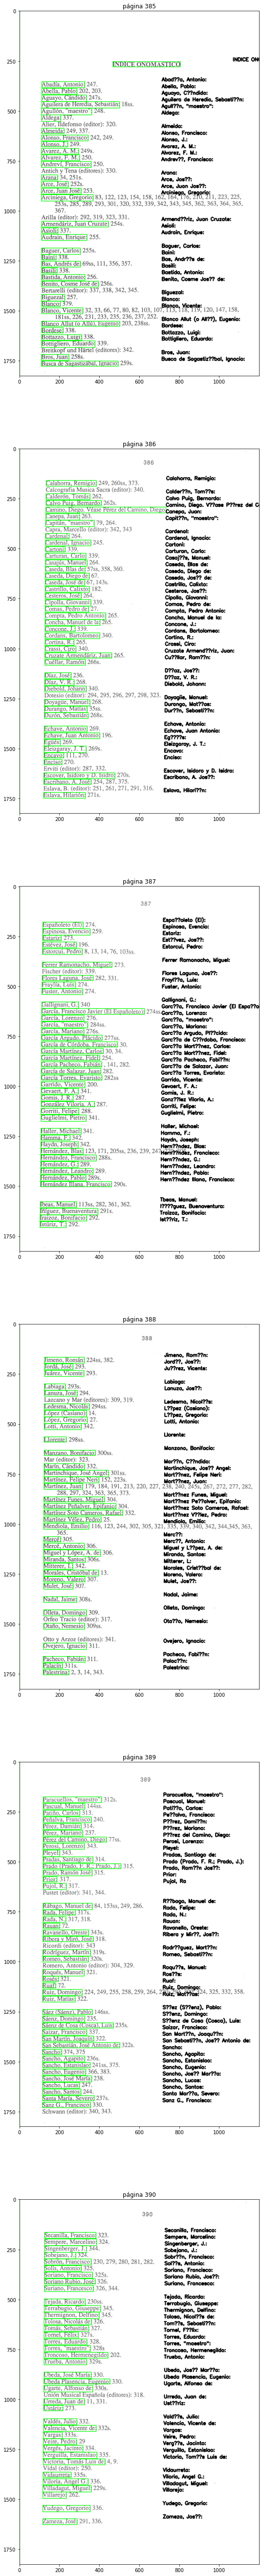

In [106]:
fig, ax = plt.subplots(len(Fotos),1,figsize=(16*len(Fotos),16*len(Fotos)))
for i in range(0,len(Fotos)):
  ax[i].imshow(mostrar_Autores(Fotos[i]),cmap=plt.cm.binary)
  ax[i].set_title('página ' + str(385+i))
plt.show()

In [107]:
Autores = Autores[2:]
print(Autores)

['Abadía, Antonio:', 'Abella, Pablo:', 'Aguayo, Cándido:', 'Aguilera de Heredia, Sebastián:', 'Agullón, "maestro":', 'Aldega:', 'Almeida:', 'Alonso, Francisco:', 'Alonso, J.:', 'Avarez, A. M.:', 'Alvarez, F. M.:', 'Andreví, Francisco:', 'Arana:', 'Arce, José:', 'Arce, Juan José:', 'Arciniega, Gregorio:', 'Armendáriz, Juan Cruzate:', 'Asioli:', 'Audrain, Enrique:', 'Baguer, Carlos:', 'Baini:', 'Bas, Andrés de:', 'Basili:', 'Bastida, Antonio:', 'Benito, Cosme José de:', 'Biguezal:', 'Blanco:', 'Blanco, Vicente:', 'Blanco Allut (o Allú), Eugenio:', 'Bordese:', 'Bottazzo, Luigi:', 'Bottigliero, Eduardo:', 'Bros, Juan:', 'Busca de Sagastizábal, Ignacio:', '', 'Calahorra, Remigio:', 'Calderón, Tomás:', 'Calvo Puig, Bernardo:', 'Camino, Diego. Véase Pérez del Camino, Diego.', 'Canepa, Juan:', 'Capitán, "maestro":', 'Cardenal:', 'Cardenal, Ignacio:', 'Cartoni:', 'Carturan, Carlo:', 'Casajús, Manuel:', 'Caseda, Blas de:', 'Caseda, Diego de:', 'Caseda, José de:', 'Castrillo, Calixto:', 'Cesteros

In [108]:
n = len(Autores)
for i in range(0,n):
  Autores[i]= Autores[i][:-1]

In [109]:
Autores[28] = Autores[28][:10] + 'ú' + Autores[28][21:]

In [110]:
Autores[40] = Autores[40][:7]

In [118]:
Autores[163] = 'Prado'

In [123]:
Autores[180] = 'Sáenz (o Sáez), Pablo'

In [128]:
Autores[182] = 'Sáenz de Cosa (o Cosca), Luis'

- **Por último, será necesario definir una función para encontrar a un autor dentro de un texto**. La mayoría de las veces salen en el libro de dos formas posibles:
  - Apellidos, Nombre
  - Nombre Apellidos

In [133]:
a = 'Apellidos, Nombre'

In [76]:
' '.join(a.split(sep=',')[::-1])

' Nombre Apellidos'

In [136]:
def buscarAutor(autor,text):
  return remove_punctuation(autor) in remove_punctuation(text) or remove_punctuation(' '.join(autor.split(sep=',')[::-1])) in remove_punctuation(text)

In [143]:
Autores[182]

'Sáenz de Cosa (o Cosca), Luis'

In [144]:
text = 'En este texto vamos a buscar a el autor luis saenz de cosa (o cosca) y nada más.'
buscarAutor(Autores[182],text)

True

### Capítulo 1
- Este quizá es el más diferente. Aquí las búsquedas las vamos a hacer haciendo búsquedas dentro de las descripciones de las obras

In [176]:
print(tipos)

['Misa', 'Salmo', 'Villancico', 'Magnificat', 'Lamentación', 'Himno', 'Rosario', 'Responsorio', 'Motete', 'Otro']


In [183]:
for i in range(1,96):
  Obras_final[i] = {}
  Obras_final[i]['Coordenadas'] = Obras[i]
  Obras_final[i]['Tipo'] = ['Sin tipo']
  Obras_final[i]['Pag'] = verPagina(i)
  Obras_final['Autor'] = ''
  pag = verPagina(i)
  n = len(Obras[i])
  Foto = []
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate(Foto,axis=0)
  texto = remove_punctuation(pytesseract.image_to_string(Foto, lang='spa', output_type=Output.DICT)['text'].replace('\n',''))
  for tipo in tipos:
    if remove_punctuation(tipo) in texto: Obras_final[i]['Tipo'].append(tipo)
  for a in Autores:
    if remove_punctuation(a) in texto or remove_punctuation(' '.join(a.split(sep=',')[::-1])) in texto:
      Obras_final[i]['Autor'] = a
      break
  if len(Obras_final[i]['Autor']) == 0: Obras_final[i]['Autor'] = 'Anónimo'
  if len(Obras_final[i]['Tipo']) > 1: Obras_final[i]['Tipo'] = Obras_final[i]['Tipo'][1:]

In [246]:
def mostrarObra(i):
  Foto = []
  pag = verPagina(i)
  n = len(Obras[i])
  for j in range(0,n):
    x,y,w,h = Obras[i][j]
    Foto.append(Pagina[pag+j][y:y+h,x:x+w])
  Foto = np.concatenate([np.zeros((70,1080,3),dtype='uint8')+255]+Foto,axis=0)
  cv2.rectangle(Foto, (0, 0), (1080,60), (119, 90, 17), 2)
  T = ''
  for t in Obras_final[i]['Tipo']:
    T = T + ', ' + remove_punctuation(t)
  T = T[2:] + '.'
  cv2.putText(Foto, 'Autor: ' + remove_punctuation(Obras_final[i]['Autor']) + '.', (50, 40), cv2.FONT_HERSHEY_SIMPLEX,0.6, (0, 0, 0), 3)
  cv2.putText(Foto, 'Tipo (o tipos) de obra: ' + T, (300, 40), cv2.FONT_HERSHEY_SIMPLEX,0.6, (0, 0, 0), 3)
  fig, ax = plt.subplots(1,1,figsize=(16,16))
  plt.imshow(Foto)
  plt.show()

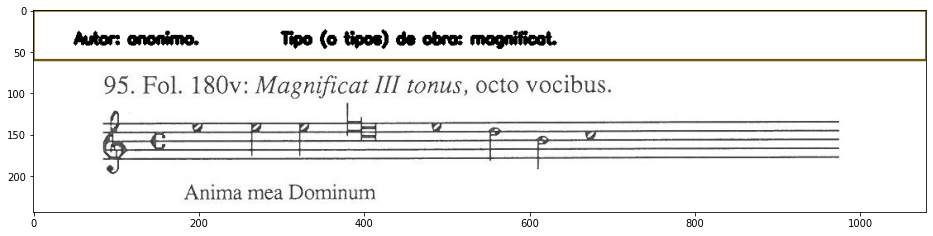

In [247]:
mostrarObra(95)

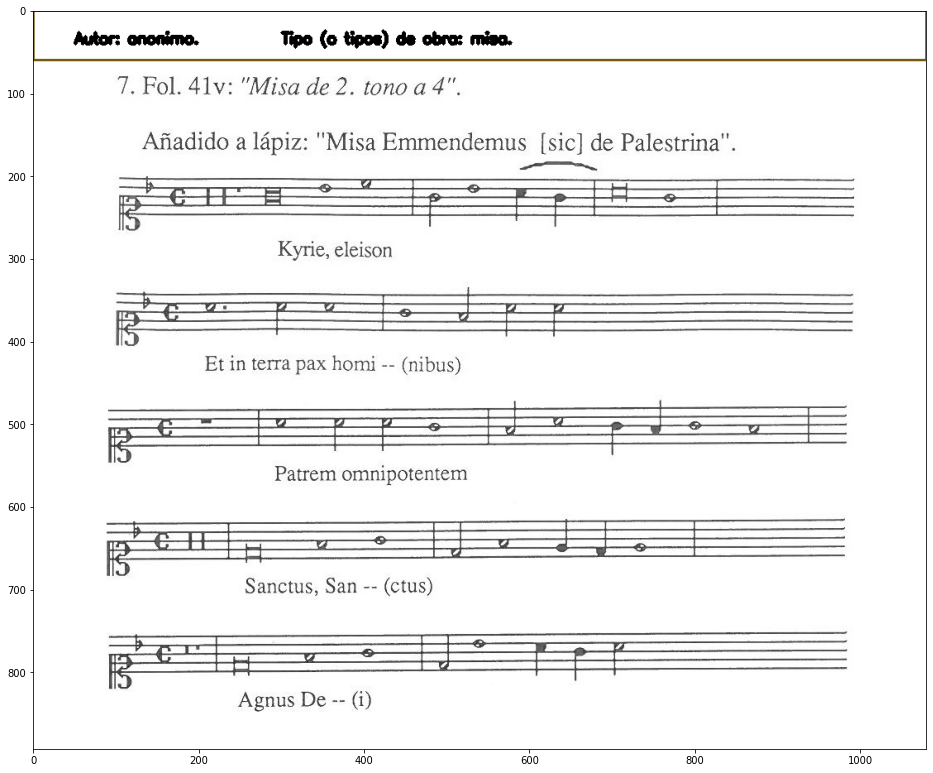

In [248]:
mostrarObra(7)